In [313]:
import numpy as np
import matplotlib.pyplot as plt

import tda_tools as tt

import ripser
import persim
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS


# 3.1. Preprocessing dataset

## 1. Read the shape into Python

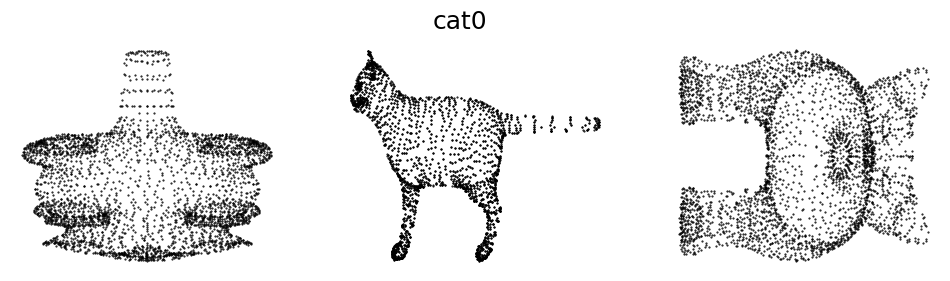

In [291]:
prefix = "cat0"
vert, surf = tt.load_data("./nonrigid3d/%s"%(prefix))

plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(vert[:, i], vert[:, (i+1)%3], 'k.', markersize=1)
    plt.axis("off")

plt.suptitle(prefix, fontsize=18)
plt.savefig("./figure/%s_sample.png"%(prefix), dpi=150)
plt.show()

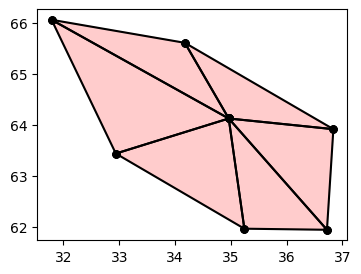

In [3]:
def draw_tri(tri_ind_set, vert):
    # yz
    for ind in tri_ind_set:
        tri = vert[np.array(ind)-1, 1:]
        
        p = plt.Polygon(tri, alpha=0.2, color='r')
        plt.gca().add_patch(p)
        
        for i in range(3):
            plt.plot([tri[i, 0], tri[(i+1)%3, 0]], [tri[i, 1], tri[(i+1)%3, 1]], 'k.-', ms=10)


target_id = 100

tri_sub = []
for surf_sub in surf:
    if target_id in surf_sub:
        tri_sub.append(surf_sub)
        
plt.figure(figsize=(4, 3))
draw_tri(tri_sub, vert)
plt.show()

## 2. Compute geodesic distance matrix

In [288]:
wgraph = tt.gen_wgraph(vert, surf)
dmat = tt.compute_geodesic(wgraph)

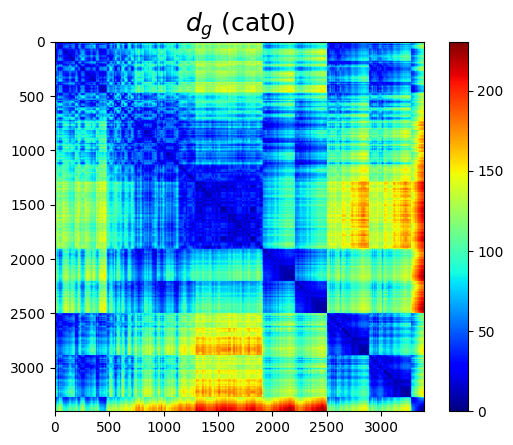

In [292]:
plt.figure()
plt.imshow(dmat, cmap="jet")
plt.colorbar()

plt.title(r"$d_g$ (%s)"%(prefix), fontsize=18)
plt.savefig("./figure/geodesic_distance_%s.png"%(prefix), dpi=150)
plt.show()

*Run "compute_distance.py"* for more samples

## 3. Subsample 200 points via FPS using dG

In [298]:
prefix = "cat0"
geom = tt.load_distance(prefix, "./processed_geodesic/")
id_fps = tt.farthest_point_sampling(geom["dm"], start_id=0, nsample=200)
dmat_sub = geom["dm"][id_fps, :][:, id_fps]

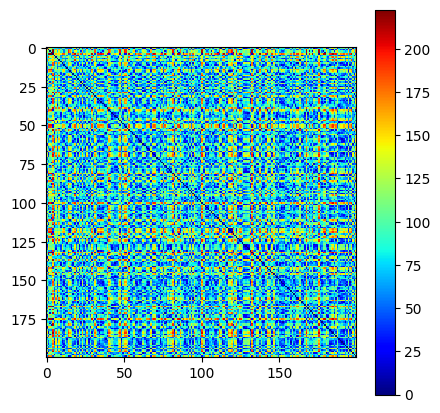

In [299]:
plt.figure(figsize=(5, 5))
plt.imshow(dmat_sub, interpolation="none", vmin=0, vmax=None, cmap="jet")
plt.colorbar()
plt.show()

## 4. Compute the Vietoris-Rips persistence diagrmas

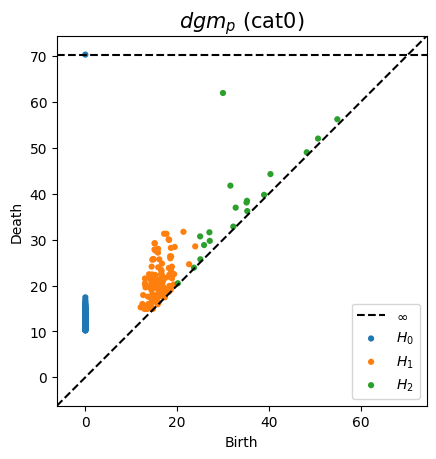

In [301]:
results = ripser.ripser(dmat_sub, distance_matrix=True, maxdim=2)

plt.figure()
persim.plot_diagrams(results['dgms'], show=False)
plt.title(r"$dgm_p$ (%s)"%(prefix), fontsize=15)
plt.savefig("./figures/dgm_%s.png"%(prefix), dpi=150)
plt.show()

In [ ]:
# visualize data points

### validation

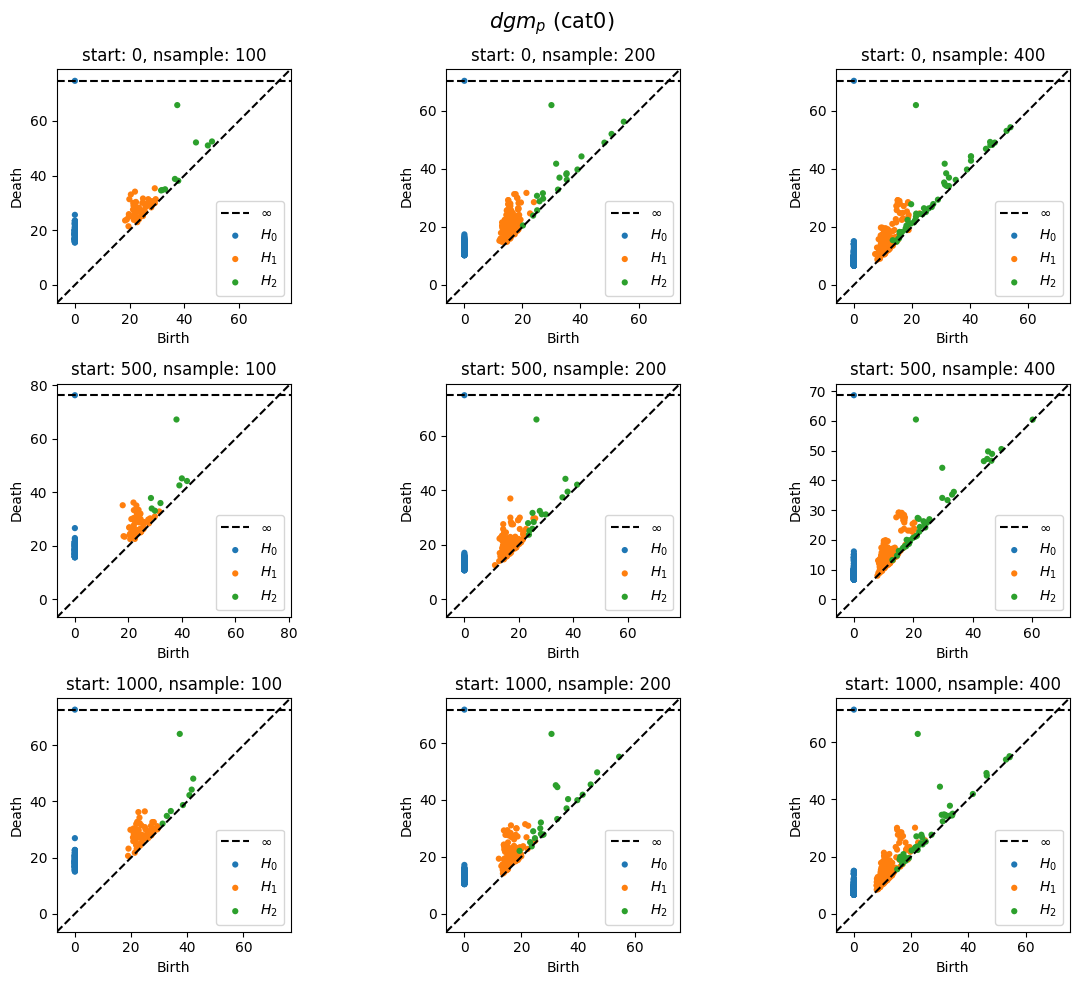

In [302]:
start_id_set = [0, 500, 1000]
nsamples = [100, 200, 400]

fig, axs = plt.subplots(len(start_id_set), len(nsamples), figsize=(12, 10))
for i, start_id in enumerate(start_id_set):
    for j, ns in enumerate(nsamples):
        id_far = tt.farthest_point_sampling(geom["dm"], start_id, ns)
        dmat_sample = geom["dm"][:, id_far][id_far, :]
        
        plt.axes(axs[i][j])
        results = ripser.ripser(dmat_sample, distance_matrix=True, maxdim=2)
        persim.plot_diagrams(results["dgms"])
        
        plt.title("start: %d, nsample: %d"%(start_id, ns))
        
plt.suptitle(r"$dgm_p$ (%s)"%(prefix), fontsize=15)
plt.tight_layout()
plt.savefig("./figure/dgm_fps_validation.png")

plt.show()


## 5-6. Create and save the stucture

Check *compute_geodesic.py*

# 3.2. Distance matrix using a coarse geometric feature

In [303]:
import os

fdir = "./processed_geodesic/"
prefix_set = [f for f in os.listdir(fdir) if ".pkl" in f]
prefix_set.sort()

names = []
diams = np.zeros(len(prefix_set))

for i, prefix in enumerate(prefix_set):
    gdata = tt.load_distance(prefix, fdir=fdir)
    names.append(gdata["name"])
    diams[i] = np.max(gdata["dm"])


Disconnected components exist in ./processed_geodesic/gorilla0.pkl, removed 136 points, 1910 left
Disconnected components exist in ./processed_geodesic/gorilla1.pkl, removed 125 points, 1915 left
Disconnected components exist in ./processed_geodesic/gorilla10.pkl, removed 134 points, 1910 left
Disconnected components exist in ./processed_geodesic/gorilla11.pkl, removed 118 points, 1918 left
Disconnected components exist in ./processed_geodesic/gorilla12.pkl, removed 127 points, 1914 left
Disconnected components exist in ./processed_geodesic/gorilla13.pkl, removed 119 points, 1917 left
Disconnected components exist in ./processed_geodesic/gorilla14.pkl, removed 100 points, 1926 left
Disconnected components exist in ./processed_geodesic/gorilla15.pkl, removed 103 points, 1925 left
Disconnected components exist in ./processed_geodesic/gorilla16.pkl, removed 126 points, 1914 left
Disconnected components exist in ./processed_geodesic/gorilla17.pkl, removed 134 points, 1914 left
Disconnected

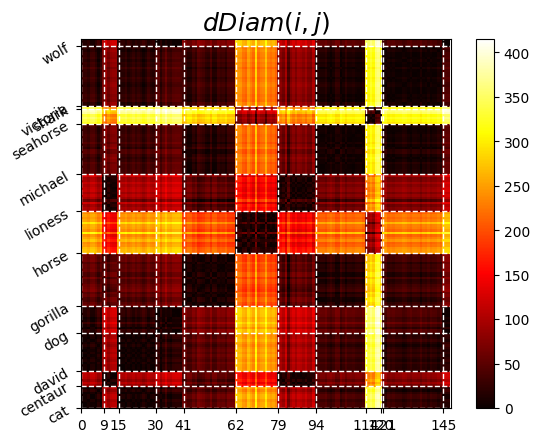

In [308]:
dDiam = np.abs(diams[...,None] - diams[None,...])

plt.figure()
plt.imshow(dDiam, cmap="hot", interpolation="none")
plt.colorbar()
tt.divide_boundaries(prefix_set)
plt.title(r"$dDiam(i, j)$", fontsize=18)
plt.savefig("./figure/dDiam.png", dpi=150)
plt.show()

# 3.3 Distance matrix based on $d_E$ and Bottleneck distance

## $D_{E, \infty}$

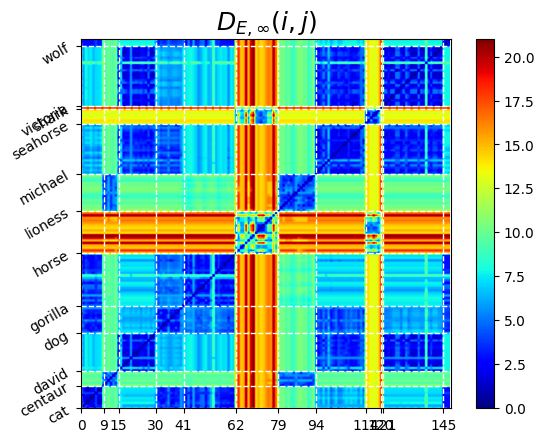

In [309]:
bdata = tt.load_pkl("./de_bottleneck.pkl")

plt.figure()
plt.imshow(bdata["dist"], cmap="jet")
tt.divide_boundaries(bdata["names"])
plt.colorbar()
plt.title(r"$D_{E, \infty}(i, j)$", fontsize=18)
plt.savefig("./figure/de_bottleneck.png", dpi=150)
plt.show()

# 3.4 Distance matrices based on $d_G$ and Wasserstein distance

## $D_{G, 1}(i, j)$

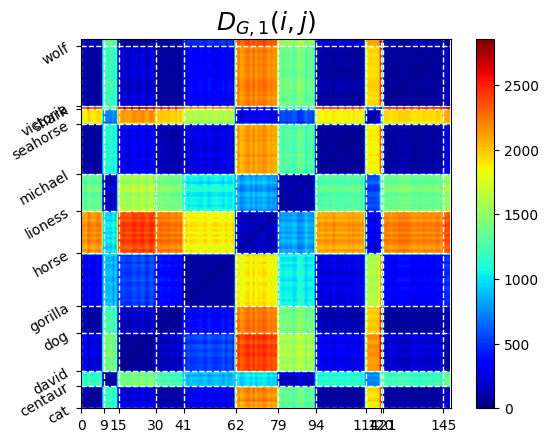

In [310]:
wdata_1 = tt.load_pkl("./dg_wasserstein_1.pkl")
true_id, matching = tt.get_true_class(wdata_1["names"])

plt.figure()
plt.imshow(wdata_1["dist"], cmap="jet")
tt.divide_boundaries(wdata_1["names"])
plt.colorbar()
plt.title(r"$D_{G, 1}(i, j)$", fontsize=18)
plt.savefig("./figure/dg_wasserstein_1.png", dpi=150)
plt.show()

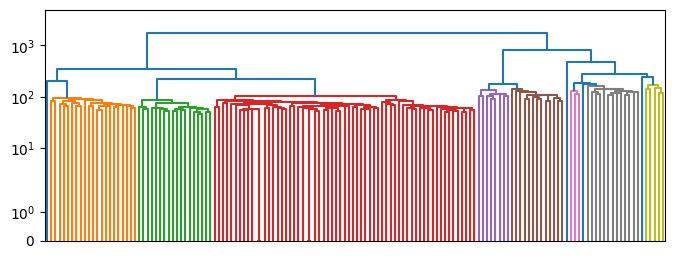

In [311]:
cluster_id = tt.hierarchical_clustering(wdata_1["dist"], 11, method="average")
wdata_1["cluster_id"] = cluster_id

square_mat = squareform(wdata_1["dist"])
linkage = hierarchy.linkage(square_mat, method="average")

plt.figure(figsize=(8, 3))
hierarchy.dendrogram(linkage, no_labels=True, color_threshold=170)
plt.yscale("symlog")
plt.ylim([0, 5e3])
plt.savefig("./figure/dg_wasserstein_1_dendrogram.png", dpi=150)
plt.show()

/tmp/ipykernel_12609/3555086922.py:3: RuntimeWarning: divide by zero encountered in log10
  tt.draw_with_dendrogram(linkage, np.log10(sort_mat), np.array(cluster_id[res_order]), cth=170)


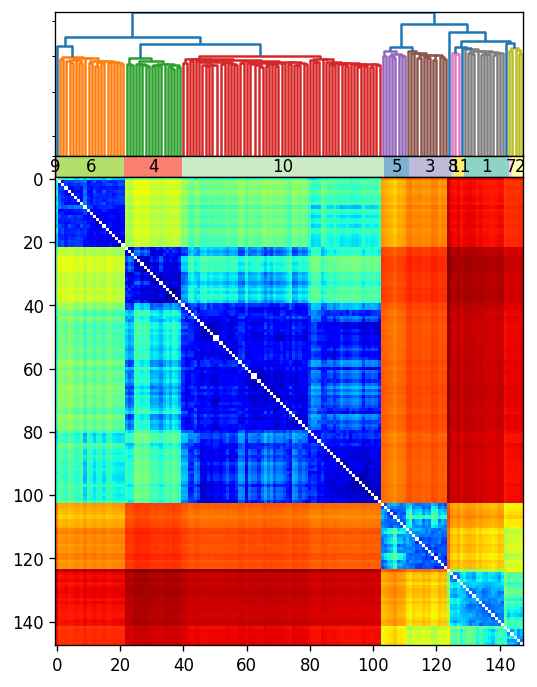

In [312]:
sort_mat, link, res_order = tt.sort_matrix(wdata_1["dist"], method="average")

tt.draw_with_dendrogram(linkage, np.log10(sort_mat), np.array(cluster_id[res_order]), cth=170)
plt.savefig("./figure/dg_wasserstein_1_sort.png", dpi=150)
plt.show()

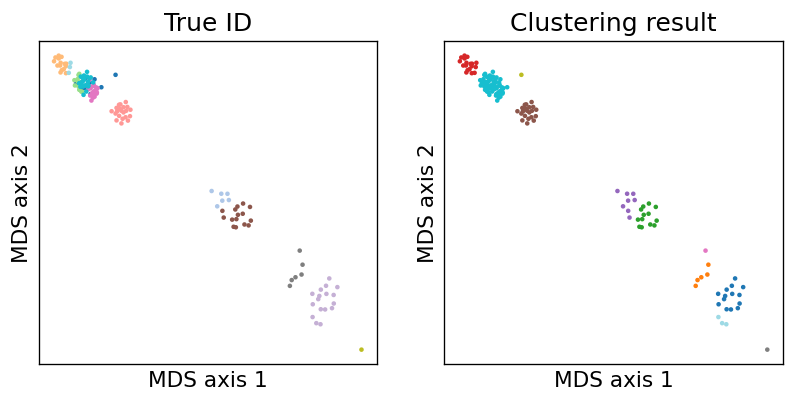

In [315]:
true_id, matching = tt.get_true_class(prefix_set)

embed = MDS(n_components=2, normalized_stress="auto", dissimilarity="precomputed", random_state=200)
r_embed = embed.fit_transform(wdata_1["dist"])

plt.figure(figsize=(8, 3.5), dpi=120)
plt.subplot(121)
plt.scatter(r_embed[:, 0], r_embed[:, 1], s=3, c=true_id, cmap="tab20")
plt.xticks([]); plt.yticks([])
plt.xlabel("MDS axis 1", fontsize=13)
plt.ylabel("MDS axis 2", fontsize=13)
plt.title("True ID", fontsize=15)

plt.subplot(122)
plt.scatter(r_embed[:, 0], r_embed[:, 1], s=3, c=cluster_id, cmap="tab20")
plt.xticks([]); plt.yticks([])
plt.xlabel("MDS axis 1", fontsize=13)
plt.ylabel("MDS axis 2", fontsize=13)
plt.title("Clustering result", fontsize=15)

plt.savefig("./figure/dg_wasserstein_1_mds.png", dpi=150)
plt.show()

## $D_{G, \infty} (i, j)$

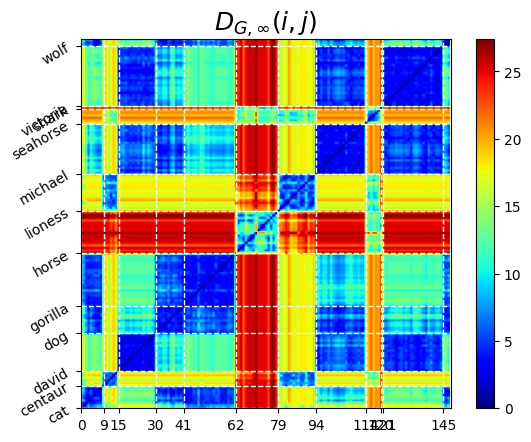

In [317]:
wdata_inf = tt.load_pkl("./dg_wasserstein_inf.pkl")
    
plt.figure()
plt.imshow(wdata_inf["dist"], cmap="jet")
tt.divide_boundaries(wdata_inf["names"])
plt.title(r"$D_{G, \infty}(i, j)$", fontsize=18)
plt.colorbar()
plt.savefig("./figure/dg_wasserstein_inf.png", dpi=150)
plt.show()

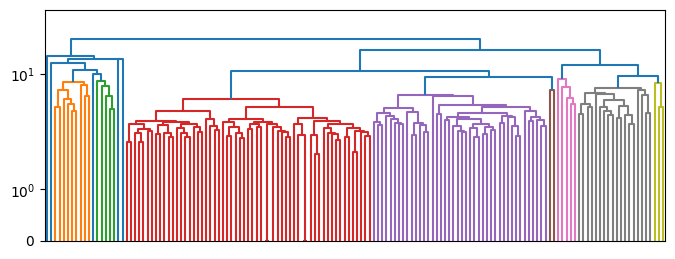

In [319]:
cluster_id = tt.hierarchical_clustering(wdata_inf["dist"], 11, method="average")
wdata_inf["cluster_id"] = cluster_id

square_mat = squareform(wdata_inf["dist"])
linkage = hierarchy.linkage(square_mat, method="average")

plt.figure(figsize=(8, 3))
hierarchy.dendrogram(linkage, no_labels=True, color_threshold=9)
plt.yscale("symlog")
plt.ylim([0, 5e1])
plt.savefig("./figure/dg_wasserstein_inf_dendrogram.png", dpi=150)
plt.show()

/tmp/ipykernel_12609/170886826.py:3: RuntimeWarning: divide by zero encountered in log10
  tt.draw_with_dendrogram(linkage, np.log10(sort_mat), np.array(cluster_id[res_order]), cth=9)


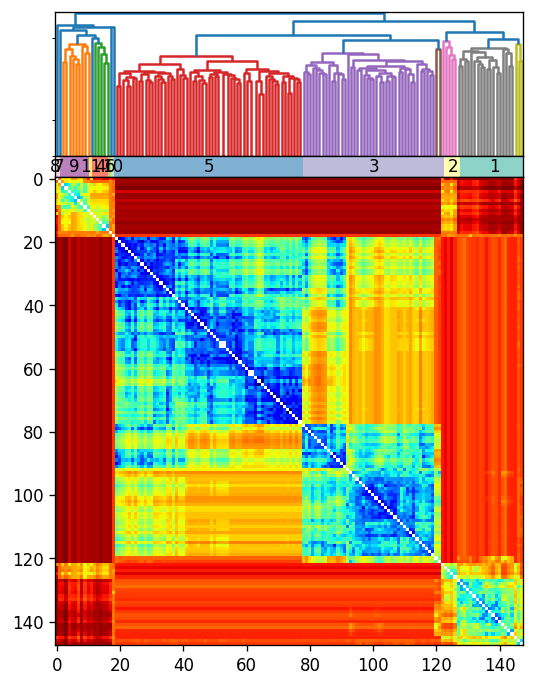

In [320]:
sort_mat, link, res_order = tt.sort_matrix(wdata_inf["dist"], method="average")

tt.draw_with_dendrogram(linkage, np.log10(sort_mat), np.array(cluster_id[res_order]), cth=9)
plt.savefig("./figure/dg_wasserstein_inf_sort.png", dpi=150)
plt.show()

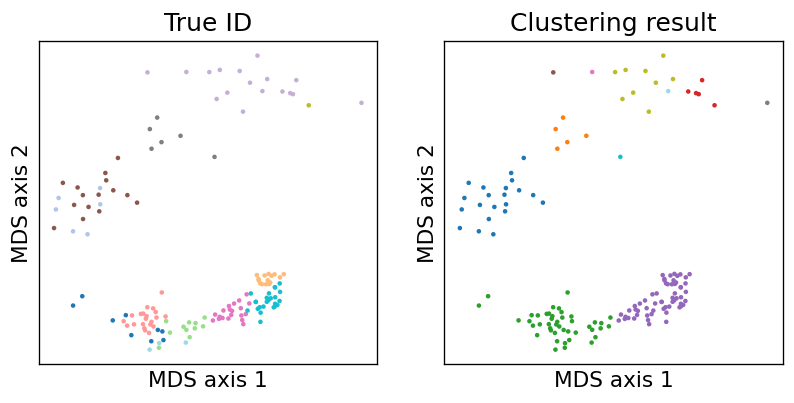

In [322]:
true_id, matching = tt.get_true_class(prefix_set)

embed = MDS(n_components=2, normalized_stress="auto", dissimilarity="precomputed", random_state=200)
r_embed = embed.fit_transform(wdata_inf["dist"])

plt.figure(figsize=(8, 3.5), dpi=120)
plt.subplot(121)
plt.scatter(r_embed[:, 0], r_embed[:, 1], s=3, c=true_id, cmap="tab20")
plt.xticks([]); plt.yticks([])
plt.xlabel("MDS axis 1", fontsize=13)
plt.ylabel("MDS axis 2", fontsize=13)
plt.title("True ID", fontsize=15)

plt.subplot(122)
plt.scatter(r_embed[:, 0], r_embed[:, 1], s=3, c=cluster_id, cmap="tab20")
plt.xticks([]); plt.yticks([])
plt.xlabel("MDS axis 1", fontsize=13)
plt.ylabel("MDS axis 2", fontsize=13)
plt.title("Clustering result", fontsize=15)

plt.savefig("./figure/dg_wasserstein_inf_mds.png", dpi=150)
plt.show()

## distance

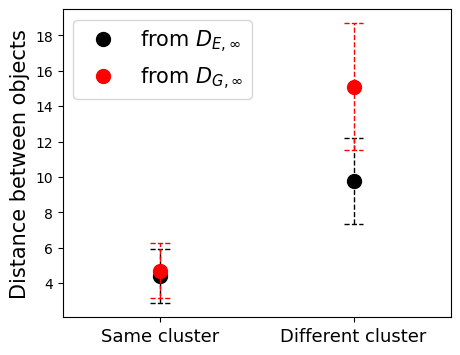

In [370]:
def distance_within_out_class(dist, true_id):
    in_, out_ = [], []
    N = len(true_id)
    for i in range(N):
        for j in range(N):
            if i == j: continue
        
            if true_id[i] == true_id[j]:
                in_.append(dist[i, j])
            else:
                out_.append(dist[i, j])
                
    return in_, out_


def show_with_error(data1, data2, c='k', label=None):
    # ns = [len(d) for d in (data1, data2)]
    ms = [np.average(x) for x in (data1, data2)]
    ss = [np.std(x)/2 for x in (data1, data2)]
    w = 0.05
    
    plt.plot([0, 1], ms, '.', ms=20, c=c, label=label)
    for i in range(2):
        # plt.plot([i, i], [ms[i]-ss[i]/np.sqrt(ns[i]) * 1.96, ms[i]+ss[i]/np.sqrt(ns[i]) * 1.96], '--', c=c, lw=1)
        plt.plot([i, i], [ms[i]-ss[i], ms[i]+ss[i]], '--', c=c, lw=1)
        plt.plot([i-w, i+w], [ms[i]-ss[i], ms[i]-ss[i]], '--', c=c, lw=1)
        plt.plot([i-w, i+w], [ms[i]+ss[i], ms[i]+ss[i]], '--', c=c, lw=1)



true_id, _ = tt.get_true_class(bdata["names"])

bin, bout = distance_within_out_class(bdata["dist"], true_id)
win, wout = distance_within_out_class(wdata_inf["dist"], true_id)

plt.figure(figsize=(5, 4))

show_with_error(bin, bout, label=r"from $D_{E, \infty}$")
show_with_error(win, wout, 'r', label=r"from $D_{G, \infty}$")
plt.legend(fontsize=15, loc="upper left")

plt.xlim([-0.5, 1.5])
plt.xticks([0, 1], labels=["Same cluster", "Different cluster"], fontsize=13)
plt.ylabel("Distance between objects", fontsize=15)
plt.show()

# Compute ROC

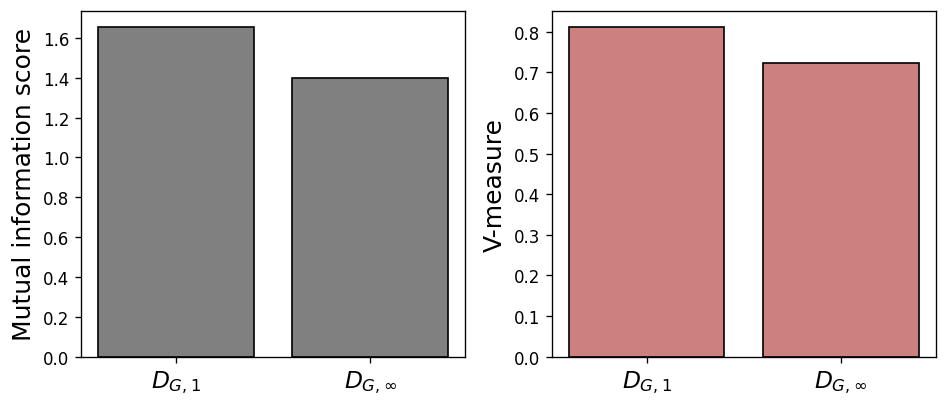

In [448]:
from sklearn.metrics import mutual_info_score, v_measure_score

cluster_id_set = (wdata_1["cluster_id"], wdata_inf["cluster_id"])

def set_labels():
    plt.xticks([0, 1], labels=(r"$D_{G, 1}$", r"$D_{G, \infty}$"), fontsize=14)

plt.figure(figsize=(8, 3.5), dpi=120)
plt.subplot(121)
plt.bar([0, 1], [mutual_info_score(true_id, x) for x in cluster_id_set], edgecolor="k", facecolor=(0.5, 0.5, 0.5))
set_labels()
plt.ylabel("Mutual information score", fontsize=15)

plt.subplot(122)
plt.bar([0, 1], [v_measure_score(true_id, x) for x in cluster_id_set], edgecolor="k", facecolor=(0.8, 0.5, 0.5))
set_labels()
plt.ylabel("V-measure", fontsize=15)

plt.tight_layout()
plt.show()
